# FinalProject_Part4_Model Draft 2B (Demo vs Exploit Type)

## 2B) Random Forest (Input: Demographics; Output: Exploitation Type)

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import random
import matplotlib.pyplot as plt
import pdb

C:\Users\ellei\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Read Cleaned Global Data
GD_data_final = pd.read_csv('assets/GD_data_final.csv')
GD_data_final.head()

,yearOfRegistration,gender,majorityStatus,ageBroad_mid,citizenshipRegion,citizenshipGeoCategory,exploitationRegion,exploitationGeoCategory,mocDebtBondage,mocTakesEarnings,...,tosProstitution,tosPornography,tosRemoteInteractiveServices,tosPrivateSexualServices,tosNotSpecified,rrIntimatePartner,rrFriend,rrFamily,rrOther,rrUnknown
0,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2004,Female,Adult,19.0,Eastern_Europe,Europe,Eastern_Europe,Europe,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,1,0,...,0,0,0,0,1,0,0,0,0,1
3,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,1,0,...,0,0,0,0,1,0,0,0,0,1
4,2012,Female,Minor,13.0,North_America,North_America,North_America,North_America,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Read Demographic vs Exploitation Geo Data
demo_exptype_calc = pd.read_csv('assets/demo_exptype_calc.csv')
demo_exptype_calc.head()

,yearOfRegistration,ageBroad_mid,g_Female,g_Male,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,...,cg_North_America,cg_South_America,cg_Unknown,isForcedLabour,isSexualExploit,isOtherExploit,isSexAndLabour,isForcedMarriage,isForcedMilitary,isOrganRemoval
0,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2004,19.0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2012,13.0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [4]:
### Since Exploitation Type are not comletely mutually exclusive (i.e. One can be both isSexualExploit and isForcedLabour, 
### and thus isSexAndLabour), change those rows to just 1 for isSexAndLabour - nothing else

def nullify_Sex(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isSexualExploit']

def nullify_Labor(x):
    if x['isSexAndLabour'] == 1:
        return 0
    else:
        return x['isForcedLabour']
    
demo_exptype_calc['isSexualExploit'] = demo_exptype_calc.apply(nullify_Sex,axis=1)
demo_exptype_calc['isForcedLabour'] = demo_exptype_calc.apply(nullify_Labor,axis=1)

In [5]:
GD_data_final.columns

Index([u'yearOfRegistration', u'gender', u'majorityStatus', u'ageBroad_mid',
       u'citizenshipRegion', u'citizenshipGeoCategory', u'exploitationRegion',
       u'exploitationGeoCategory', u'mocDebtBondage', u'mocTakesEarnings',
       u'mocRestrictsFinancialAccess', u'mocThreats', u'mocPsychologicalAbuse',
       u'mocPhysicalAbuse', u'mocSexualAbuse', u'mocFalsePromises',
       u'mocPsychoactiveSubstances', u'mocRestrictsMovement',
       u'mocRestrictsMedicalCare', u'mocExcessiveWorkingHours',
       u'mocUsesChildren', u'mocThreatOfLawEnforcement',
       u'mocWithholdsNecessities', u'mocWithholdsDocuments', u'mocOther',
       u'mocNotSpecified', u'isForcedLabour', u'isSexualExploit',
       u'isOtherExploit', u'isSexAndLabour', u'isForcedMarriage',
       u'isForcedMilitary', u'isOrganRemoval', u'tolAgriculture',
       u'tolAquafarming', u'tolBegging', u'tolConstruction',
       u'tolDomesticWork', u'tolHospitality', u'tolIllicitActivities',
       u'tolManufacturing', u'tolM

In [6]:
### Consolidate all types of exploitation into one column

def combine_expType(x):
    if x['isForcedLabour'] == 1:
        return 'Forced Labour'
    elif x['isSexualExploit'] == 1:
        return 'Sexual Exploit'
    elif x['isOtherExploit'] == 1:
        return 'Other Exploit'
    elif x['isSexAndLabour'] == 1:
        return 'Sex and Labour'
    elif x['isForcedMarriage'] == 1:
        return 'Forced Marriage'
    elif x['isForcedMilitary'] == 1:
        return 'Forced Military'
    elif x['isOrganRemoval'] == 1:
        return 'Organ Removal'
    else:
        return 0
        
demo_exptype_calc['ExploitType'] = demo_exptype_calc.apply(combine_expType,axis=1)
demo_exptype_calc.head()

,yearOfRegistration,ageBroad_mid,g_Female,g_Male,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,...,cg_South_America,cg_Unknown,isForcedLabour,isSexualExploit,isOtherExploit,isSexAndLabour,isForcedMarriage,isForcedMilitary,isOrganRemoval,ExploitType
0,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0.0,1.0,0,0,0,0,0,Sexual Exploit
1,2004,19.0,1,0,1,0,0,0,1,0,...,0,0,0.0,1.0,0,0,0,0,0,Sexual Exploit
2,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0.0,1.0,0,0,0,0,0,Sexual Exploit
3,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0.0,1.0,0,0,0,0,0,Sexual Exploit
4,2012,13.0,1,0,0,0,0,0,0,0,...,0,0,1.0,0.0,0,0,0,0,0,Forced Labour


In [7]:
demo_exptype_calc.columns

Index([u'yearOfRegistration', u'ageBroad_mid', u'g_Female', u'g_Male',
       u'ms_Adult', u'cr_Central_Asia', u'cr_East_Africa', u'cr_East_Asia',
       u'cr_Eastern_Europe', u'cr_Middle_East', u'cr_North_America',
       u'cr_Northeast_Africa', u'cr_South_America', u'cr_South_Asia',
       u'cr_Southeast_Asia', u'cr_Southeastern_Europe', u'cr_Unknown',
       u'cr_West_Africa', u'cg_Africa', u'cg_Asia', u'cg_Europe',
       u'cg_Middle_East', u'cg_North_America', u'cg_South_America',
       u'cg_Unknown', u'isForcedLabour', u'isSexualExploit', u'isOtherExploit',
       u'isSexAndLabour', u'isForcedMarriage', u'isForcedMilitary',
       u'isOrganRemoval', u'ExploitType'],
      dtype='object')

In [8]:
     demo_exptype_headers = ['yearOfRegistration','ageBroad_mid', 'g_Female', 'ms_Adult', 
                              'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                              'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                              'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                              'cg_Africa', 'cg_Asia', 'cg_Europe', 'cg_Middle_East', 'cg_North_America', 'cg_South_America', 
                              'ExploitType']
demo_exptype_calc[demo_exptype_headers[:25]]

,yearOfRegistration,ageBroad_mid,g_Female,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,cr_North_America,...,cr_Southeast_Asia,cr_Southeastern_Europe,cr_West_Africa,cg_Africa,cg_Asia,cg_Europe,cg_Middle_East,cg_North_America,cg_South_America,ExploitType
0,2010,19.0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Sexual Exploit
1,2004,19.0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,Sexual Exploit
2,2010,19.0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Sexual Exploit
3,2010,19.0,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Sexual Exploit
4,2012,13.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour
5,2012,13.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour
6,2012,13.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour
7,2012,13.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour
8,2012,13.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour
9,2012,13.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Forced Labour


In [10]:
demo_exptype_calc[['ExploitType','ms_Adult']].groupby('ExploitType').count()

,ms_Adult
ExploitType,
Forced Labour,6730
Forced Marriage,50
Other Exploit,570
Sex and Labour,20
Sexual Exploit,11114


In [11]:
len(demo_exptype_calc)

18484

Random Forest Train Accuracy ::  0.937548307312
Random Forest Logistic regression Test Accuracy ::  0.935448972232
Cross validating...
Random Forest - train accuracy: 
0.935537369842
X: 
Index([u'ageBroad_mid', u'g_Female', u'ms_Adult', u'cr_Central_Asia',
       u'cr_East_Africa', u'cr_East_Asia', u'cr_Eastern_Europe',
       u'cr_Middle_East', u'cr_North_America', u'cr_Northeast_Africa',
       u'cr_South_America', u'cr_South_Asia', u'cr_Southeast_Asia',
       u'cr_Southeastern_Europe', u'cr_West_Africa'],
      dtype='object')
Feature Importance: 
[ 0.201  0.37   0.014  0.013  0.011  0.001  0.027  0.006  0.032  0.003
  0.001  0.017  0.253  0.006  0.047]


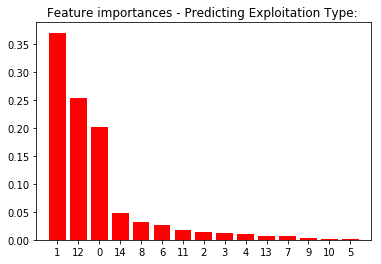

Classes: 
['Forced Labour' 'Forced Marriage' 'Other Exploit' 'Sex and Labour'
 'Sexual Exploit']
Average Probabilities by gender: 
        pp_ForcedLabor  pp_ForcedMarriage  pp_OtherExploit  pp_SexAndLabour  \
gender                                                                        
Female        0.173573           0.003192         0.037966         0.001443   
Male          0.966394           0.000000         0.010547         0.000000   

        pp_SexualExploit  
gender                    
Female          0.783841  
Male            0.023059  
Average Probabilites by majorityStatus: 
                pp_ForcedLabor  pp_ForcedMarriage  pp_OtherExploit  \
majorityStatus                                                       
Adult                 0.394460           0.002244         0.026412   
Minor                 0.261127           0.003033         0.047930   

                pp_SexAndLabour  pp_SexualExploit  
majorityStatus                                     
Adult             

In [15]:
# Multinomial Logistic Regression
def demo_exptype_main():

    demo_exptype_headers = ['ageBroad_mid', 'g_Female', 'ms_Adult', 
                              'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                              'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                              'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',
                              'ExploitType']

    ### Train Test Split - Out put col index -1 
    X = demo_exptype_calc[demo_exptype_headers[:-1]]
    y = demo_exptype_calc[demo_exptype_headers[-1]]
    train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)
    
  
    model = RandomForestClassifier(n_estimators=500)
    model.fit(train_x, train_y)

    print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
    print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))
    
    print ("Cross validating...")
    print ("Random Forest - train accuracy: ")
    print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

    print ("X: ")
    print (X.columns)
    
    #Feature Importances - Break down weights of each feature
    print ("Feature Importance: ")
    importances = model.feature_importances_.round(3)
    print (importances)
    
    ## Graphing Feature Importances
    std = np.std([importances],axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances - Predicting Exploitation Type: ")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    print ("Classes: ")
    print (model.classes_)
    
    # Predict Probabilities
    #pp = model.predict_proba(X)    
    cols = ['pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']    
    df_pp = pd.DataFrame(model.predict_proba(X).round(4),columns=cols)
    df_data_pp = GD_data_final.join(df_pp)
    #df_pp.head()
    
    # GROUP BYs different demographics
    print ("Average Probabilities by gender: ")
    print (df_data_pp[['gender','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('gender').mean())
    
    print ("Average Probabilites by majorityStatus: ")
    print (df_data_pp[['majorityStatus','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('majorityStatus').mean())

    print ("Average Probabilites by ageBroad_mid: ")
    print (df_data_pp[['ageBroad_mid','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('ageBroad_mid').mean())
    
    print ("Average Probabilites by citizenshipRegion: ")
    print (df_data_pp[['citizenshipRegion','pp_ForcedLabor', 'pp_ForcedMarriage', 'pp_OtherExploit', 'pp_SexAndLabour', 'pp_SexualExploit']].groupby('citizenshipRegion').mean())
    
if __name__ == '__main__':
  demo_exptype_main()
